###  AIML Online Capstone Project - AUTOMATIC TICKET ASSIGNMENT (Group 4)


#### Background :
In the support process, incoming incidents are analyzed and assessed by organization’s support teams to fulfill the request. 
Better allocation and effective usage of the valuable support resources will directly result in substantial cost savings. 
Currently, the incidents are created by various stakeholders and are assigned to L1/L2 teams.  
Incase L1 / L2 is unable to resolve, they will then escalate / assign the tickets to Functional teams from Applications and Infrastructure (L3 teams). 

#### Problem Statement :
L1 / L2 needs to spend time reviewing Standard Operating Procedures (SOPs) before assigning to Functional teams (Minimum ~25-30% of incidents needs to be reviewed for SOPs before ticket assignment). 
15 min is being spent for SOP review for each incident. Minimum of ~1 FTE effort needed only for incident assignment to L3 teams.
Multiple instances of incidents getting assigned to wrong functional groups (Around ~25%)
Additional effort needed for Functional teams to re-assign to right functional groups. 
During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service.!

#### Project Objectives :

Guided by powerful AI techniques 
* Classify incidents to right functional groups based on User description
* Help organizations to reduce the resolving time
* Improve productivity of Support teams

#### Data Pre-Processing
* This section of the Code deals with the Data Pre-Processing

In [154]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from langdetect import detect, detect_langs
import googletrans
from googletrans import Translator
import re
import translate
from tensorflow.keras.preprocessing.text import Tokenizer
#from googletranslate import Translator
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup
from string import digits
import string

In [155]:
import socket    
hostname = socket.gethostname()    
IPAddr = socket.gethostbyname(hostname)    
print("Your Computer Name is:" + hostname)    
print("Your Computer IP Address is:" + IPAddr) 

Your Computer Name is:Prasad-Dell-LT
Your Computer IP Address is:192.168.0.6


In [156]:
def remove_html(text):
  soup = BeautifulSoup(text,'lxml')
  html_free = soup.get_text()
  return html_free

def remove_punctuation(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

def remove_digits(list1): 
    remove_digits = str.maketrans('', '', digits) 
    list1 = [i.translate(remove_digits) for i in list1] 
    return list1

#### Use when running through google collab
from google.colab import drive
drive.mount('/drive', force_remount=True)

project_path = "/drive/My Drive/AIML_Project_Files_Final/10.Capstone Project"

In [157]:
# Please note that this Dataset has 4 more extra columns to identify the language and transilate to English
# Tried this transilation in Python using googletrans API but there is limitation on the numbers of calls, hence 
# googl sheets was used 
df = pd.read_excel("input_data_translated.xlsx", encoding="utf-8",dtype="str")

In [158]:
df.dtypes

Short description    object
Description          object
short_desc_lang      object
short_desc_en        object
description_lang     object
description_en       object
Caller               object
Assignment group     object
dtype: object

In [159]:
df.describe()

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group
count,8492,8499,8492,8492,8497,8497,8500,8500
unique,7481,7817,50,7379,36,7752,2950,74
top,password reset,the,en,password reset,en,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,7613,48,7768,56,810,3976


In [160]:
#Find the Null Values
print(df.isnull().sum())

Short description    8
Description          1
short_desc_lang      8
short_desc_en        8
description_lang     3
description_en       3
Caller               0
Assignment group     0
dtype: int64


In [161]:
# Since there are few records which are null, we decide to drop them 
df = df.dropna()

In [162]:
print(df.isnull().sum())

Short description    0
Description          0
short_desc_lang      0
short_desc_en        0
description_lang     0
description_en       0
Caller               0
Assignment group     0
dtype: int64


In [163]:
# Load original dataset gven in the project 
df1 = pd.read_excel("input_data.xlsx")
df1.head(5)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [164]:
#Remove Junk charaters from the text.. below is an example
"ç­”å¤: ticket_no1559458 : wireless guest access- hr_tool trainer".encode('ascii','ignore').decode()

': ticket_no1559458 : wireless guest access- hr_tool trainer'

In [165]:
# We are going to use the DataFrame df for further processing 
df.describe()

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group
count,8489,8489,8489,8489,8489,8489,8489,8489
unique,7478,7810,50,7376,36,7747,2948,74
top,password reset,the,en,password reset,en,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,7610,48,7760,56,810,3966


In [166]:
# There is Email ID in the Description field . we need to saperate this and store in another column 
#RegEx to find email form the text .. an example below
emails = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", df["Description"][2])
print(emails)
my_str = "Hi my name is John and email address is john.doe@somecompany.co.uk and my friend's email is jane_doe124@gmail.com"
emails = re.findall("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)", my_str)
print(emails)


['eylqgodm.ybqkwiam@gmail.com']
['john.doe@somecompany.co.uk', 'jane_doe124@gmail.com']


In [167]:
#RegEx to remove spaces from the text.. an example below
t1 = '       Hello  World       From Pankaj \t\n\r\t \t /**  Hi There             '
print('Remove all spaces using RegEx:\n', re.sub(r"\s+", " ", df["Description"][2]), sep='')  # \s matches all white spaces

a = ' '.join([item for item in df["Description"][342].split() if '@' not in item])
b = re.sub(r"received from:","",a)

print(df["Short description"][223])
print (a,"  ",b)
#print(df["Description"][223])


Remove all spaces using RegEx:
 received from: eylqgodm.ybqkwiam@gmail.com hi i cannot log on to vpn best 
probleme mit bluescreen .
shortcut opening multiple folders    shortcut opening multiple folders


In [168]:
df.head(5)

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,en,login issue,en,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,en,outlook,en,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,en,cant log in to vpn,en,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,en,unable to access hr_tool page,en,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,en,skype error,en,skype error,owlgqjme qhcozdfx,GRP_0


In [169]:
#Find and impute Null values from Short description 
short_null = df[pd.isnull(df["Short description"]) == True].index
print(short_null)

Int64Index([], dtype='int64')


In [170]:
df.count()

Short description    8489
Description          8489
short_desc_lang      8489
short_desc_en        8489
description_lang     8489
description_en       8489
Caller               8489
Assignment group     8489
dtype: int64

In [171]:
# Remove the caller names form the description. This can be done by adding the users list to the stop words
users = list(df["Caller"])
users = np.hstack(np.unique(users))
stop_words1 = list(stop_words) + list(users)

In [172]:
#df["short_desc_lang"] = ""
#df["short_desc_en"] = ""
#df["description_lang"]=""
#df["description_en"] = ""
df["emails"] = ""
df["email_type"]=""
df["short_desc_spl"] = ""
df["description_spl"] = ""
df["short_desc_len"] = ""
df["description_len"] = ""
df["no_of_splch_removed1"]=""
df["no_of_splch_removed1_pct"]=""
df["no_of_splch_removed2"]=""
df["no_of_splch_removed2_pct"]=""
df["short_desc_en_spl"] = ""
df["description_en_spl"] = ""
df["short_desc_en_len"] = ""
df["description_en_len"] = ""
df["trimmed_words"] = ""
df["trimmed_words_len"] = ""
df["trimmed_words_short"] = ""
df["trimmed_words_long"] = ""
df["mark_for_delete"]=0

x = 0

for i in tqdm(df.index):  
  short_desc = str(df["Short description"][i]).encode('ascii','ignore').decode()
  df.loc[i,"no_of_splch_removed1"] = len(df["Short description"][i]) - len(str(df["Short description"][i]).encode('ascii','ignore').decode())
  if len(df["Short description"][i]) > 0 :
      df.loc[i,"no_of_splch_removed1_pct"] = np.round((df.loc[i,"no_of_splch_removed1"]*100 / len(df["Short description"][i])),1)
  else :
      df.loc[i,"no_of_splch_removed1_pct"] = 100

  desc = str(df["Description"][i]).encode('ascii','ignore').decode()
  df.loc[i,"no_of_splch_removed2"] = len(df["Description"][i]) - len(str(df["Description"][i]).encode('ascii','ignore').decode())
  
  if len(df["Description"][i]) >0 :
    df.loc[i,"no_of_splch_removed2_pct"] = np.round((df.loc[i,"no_of_splch_removed2"]*100 / len(df["Description"][i])),1)
  else :
    df.loc[i,"no_of_splch_removed2_pct"] = 100
  # The below Funtion is to transilate the sentances to English but this free API has miliation. Hence not used. 
  # We used the pre transilated input data (using Googl sheet)
  #if b == "en" :
  #      trn = Translator().translate(short_desc, dest = "en", src = "auto")
  #      short_desc_en = trn.text 
  #      trn1 = Translator().translate(desc, dest = "en", src = "auto")
  #      Description_en = trn1.text
  #else :
  
  #The below function is to remove Junk Characters from text 
  short_desc_en = str(df["short_desc_en"][i]).encode('ascii','ignore').decode()
  Description_en =str(df["description_en"][i]).encode('ascii','ignore').decode()
  
  # Finding the first Email Address from the 'Description' column. 
  if(len(re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", df["Description"][i]))) > 0:
      df.loc[i,"emails"] = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", df["Description"][i])[0]
    #df["emails"][i] = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", df["Description"][i])
  
  #Removing the Email ID from the short description ------------------------------------
  fltr_txt = ' '.join([item for item in short_desc.split() if '@' not in item])
  fltr_txt = re.sub(r"received from:","",fltr_txt)
  alpha = ""
  for char in fltr_txt:
    if char.isspace():
      alpha+= " "
    if char.isalnum():
      alpha+= char.lower()
  df.loc[i,"short_desc_spl"] = str(" ".join(alpha.split()))
  df.loc[i,"short_desc_len"] = len(alpha.split()) 
  #df.loc[i,"no_splch_removed"] = len(fltr_txt)-len(alpha.split())  
  #Removing the Email ID from the Description-------------------------------------------------
  fltr_txt1 = ' '.join([item for item in desc.split() if '@' not in item])
  fltr_txt1 = re.sub(r"received from:","",fltr_txt1)
  alpha1 = ""
  for char in fltr_txt1:
    if char.isspace():
      alpha1+= " "
    if char.isalnum():
      alpha1+= char.lower()
  df.loc[i,"description_spl"] = str(" ".join(alpha1.split()))
  df.loc[i,"description_len"] = len(alpha1.split())  
  #----------------------------   
  fltr_txt = ' '.join([item for item in short_desc_en.split() if '@' not in item])
  fltr_txt = re.sub(r"received from:","",fltr_txt)
  alpha = ""
  for char in fltr_txt:
    if char.isspace():
      alpha+= " "
    if char.isalnum():
      alpha+= char.lower()
  df.loc[i,"short_desc_en_spl"] = str(" ".join(alpha.split()))
  df.loc[i,"short_desc_en_len"] = len(alpha.split()) 
  #---------------------------------
  fltr_txt1 = ' '.join([item for item in Description_en.split() if '@' not in item])
  fltr_txt1 = re.sub(r"received from:","",fltr_txt1)
  alpha1 = ""
  for char in fltr_txt1:
    if char.isspace():
      alpha1+= " "
    if char.isalnum():
      alpha1+= char.lower()
  df.loc[i,"description_en_spl"] = str(" ".join(alpha1.split())) 
  df.loc[i,"description_en_len"] = len(alpha1.split())
  
  #--------------------------------------  
  # Final Text after stop word removal and combining both short and long description
  
  df.loc[i,"trimmed_words_short"] = " ".join([item for item in df["short_desc_en_spl"][i].split() if item not in stop_words1])
  df.loc[i,"trimmed_words_long"] = " ".join([item for item in df["description_en_spl"][i].split() if item not in stop_words1])

  if df["short_desc_en_spl"][i] == df["description_en_spl"][i] : 
    df.loc[i,"trimmed_words"] = " ".join([item for item in df["short_desc_en_spl"][i].split() if item not in stop_words1])
  else :
    df.loc[i,"trimmed_words"] = " ".join([item for item in df["short_desc_en_spl"][i].split() if item not in stop_words1])+" "+" ".join([item for item in df["description_en_spl"][i].split() if item not in stop_words1])
  #Mark records with lot of junk characters for  delete -----------------------------------------------
  df.loc[i,"trimmed_words_len"] = len(df["trimmed_words"][i].split())
  if df["trimmed_words_len"][i] <= 1:
    df.loc[i,"mark_for_delete"]= 1
  if df["no_of_splch_removed1_pct"][i]>50: # sentances with more than 50% junk
    df.loc[i,"mark_for_delete"]= 1
  #if i in short_null :
  #  df.loc[i,"mark_for_delete"]= 1
  #Progress Bar-----------------------------------------------------------------------------------------------------------
  #if np.mod(i,1000) == 0:
    #print("\n")
  #  print(np.round((i*100/len(df))),"% ", end = "")
  #if np.mod(i,100) == 0:
  #  print("=", end = "")
  

100%|██████████| 8489/8489 [01:22<00:00, 102.43it/s]


In [173]:
df['trimmed_words_short'] = remove_digits(df['trimmed_words_short'])
df['trimmed_words_long'] = remove_digits(df['trimmed_words_long'])
df['trimmed_words_short'] = df['trimmed_words_short'].apply(lambda x: remove_punctuation(x))
df['trimmed_words_long'] = df['trimmed_words_long'].apply(lambda x: remove_punctuation(x))
df['trimmed_words_short'] = df['trimmed_words_short'].apply(lambda x: remove_html(x))
df['trimmed_words_long'] = df['trimmed_words_long'].apply(lambda x: remove_html(x))
df.head()

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group,emails,email_type,...,no_of_splch_removed2_pct,short_desc_en_spl,description_en_spl,short_desc_en_len,description_en_len,trimmed_words,trimmed_words_len,trimmed_words_short,trimmed_words_long,mark_for_delete
0,login issue,-verified user details.(employee# & manager na...,en,login issue,en,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,,,...,0,login issue,verified user detailsemployee manager name che...,2,32,login issue verified user detailsemployee mana...,23,login issue,verified user detailsemployee manager name che...,0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,en,outlook,en,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,hmjdrvpb.komuaywn@gmail.com,,...,0,outlook,hello team my meetingsskype meetings etc are n...,1,22,outlook hello team meetingsskype meetings etc ...,14,outlook,hello team meetingsskype meetings etc appearin...,0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,en,cant log in to vpn,en,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,eylqgodm.ybqkwiam@gmail.com,,...,0,cant log in to vpn,hi i cannot log on to vpn best,5,8,cant log vpn hi cannot log vpn best,8,cant log vpn,hi cannot log vpn best,0
3,unable to access hr_tool page,unable to access hr_tool page,en,unable to access hr_tool page,en,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,,,...,0,unable to access hrtool page,unable to access hrtool page,5,5,unable access hrtool page,4,unable access hrtool page,unable access hrtool page,0
4,skype error,skype error,en,skype error,en,skype error,owlgqjme qhcozdfx,GRP_0,,,...,0,skype error,skype error,2,2,skype error,2,skype error,skype error,0


In [176]:
df["trimmed_words_long"][0]

'verified user detailsemployee manager name checked user name ad reset password advised user login check caller confirmed able login issue resolved'

In [178]:
df["Description"][0]

'-verified user details.(employee# & manager name)\n-checked the user name in ad and reset the password.\n-advised the user to login and check.\n-caller confirmed that he was able to login.\n-issue resolved.'

In [179]:
#Word Tokenizer
numword = 2000
t = Tokenizer(num_words=numword)
t.fit_on_texts((df["short_desc_en_spl"]))
t1 = Tokenizer(num_words=numword)
t1.fit_on_texts((df["description_en_spl"]))


In [180]:
#build a word Corpus
short_desc_words = pd.DataFrame()
short_desc_words["word_index"] = ""
short_desc_words["word"] = ""
short_desc_words["word_count"] = ""

desc_words = pd.DataFrame()
desc_words["word_index"] = ""
desc_words["word"] = ""
desc_words["word_count"] = ""


i = 0
for word in tqdm(t.word_index):
    if not word in stop_words1:
        if i<= 1500 :
            new_row = {'word_index':t.word_index[word], 'word':word, 'word_count':t.word_counts[word]}
            short_desc_words = short_desc_words.append(new_row, ignore_index=True)
            i = i+1

        
i = 0
for word in tqdm(t1.word_index):
    if not word in stop_words1:
        if i<= 1500 :
            new_row = {'word_index':t1.word_index[word], 'word':word, 'word_count':t1.word_counts[word]}
            desc_words = desc_words.append(new_row, ignore_index=True)
            i = i+1


100%|██████████| 20441/20441 [00:04<00:00, 4326.19it/s]


In [181]:
short_desc_words

,word_index,word,word_count
0,5,job,978
1,7,jobscheduler,959
2,9,password,889
3,10,erp,853
4,11,failed,829
...,...,...,...
1496,1603,lndypaqg,3
1497,1604,dhqwtcsr,3
1498,1605,we111,3
1499,1606,outputs,3


In [182]:
desc_words

,word_index,word,word_count
0,9,please,2072
1,14,yesnona,1568
2,17,password,1205
3,20,user,1147
4,21,erp,1144
...,...,...,...
1496,1613,second,13
1497,1614,ph,13
1498,1615,sometimes,13
1499,1616,across,13


In [183]:
short_desc_words.to_csv("short_desc_words.csv")
desc_words.to_csv("desc_words.csv")

In [184]:
df["flg_account_related"]=0
df["flg_crm"]=0
df["flg_engineering"]=0
df["flg_erp"]=0
df["flg_failed"]=0
df["flg_help"]=0
df["flg_install"]=0
df["flg_job"]=0
df["flg_laptop"]=0
df["flg_mobile"]=0
df["flg_network"]=0
df["flg_outlook"]=0
df["flg_printer"]=0
df["flg_skype"]=0
df["flg_ticket_update"]=0
df["flg_vpn"]=0
df["flg_windows"]=0
df["host_related"]=0
#df["mobile"]=0
df["blank_call"]=0
df["setup_ws"]=0

In [185]:

for i in tqdm(df.index):
#---------------------------------------------------------------------
    if df["emails"][i].find("gmail") >= 0:
        df.loc[i,"email_type"] = "gmail"
    else: 
        if df["emails"][i].find("monitoring_tool@") >=0:
            df.loc[i,"email_type"] = "monitoring_tool"
        else:
            if df["emails"][i].find("company") >=0:
                df.loc[i,"email_type"] = "company"
            else :
                df.loc[i,"email_type"] = "others"
    
    if df["trimmed_words"][i].find("access") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("account") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("locked") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("login") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("logon") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("password") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("passwordmanagementtool") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("passwords") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("reset") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("tologin") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("unlock") >= 0 :
        df.loc[i,"flg_account_related"] = 1
    if df["trimmed_words"][i].find("user") >= 0 :
        df.loc[i,"flg_account_related"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("circuit") >= 0 :
        df.loc[i,"flg_network"] = 1
    if df["trimmed_words"][i].find("connection") >= 0 :
        df.loc[i,"flg_network"] = 1
    if df["trimmed_words"][i].find("network") >= 0 :
        df.loc[i,"flg_network"] = 1
    if df["trimmed_words"][i].find("outage") >= 0 :
        df.loc[i,"flg_network"] = 1
    if df["trimmed_words"][i].find("server") >= 0 :
        df.loc[i,"flg_network"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("vpn") >= 0 :
        df.loc[i,"flg_vpn"] = 1
    if df["trimmed_words"][i].find("vpncompanycom") >= 0 :
        df.loc[i,"flg_vpn"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("computer") >= 0 :
        df.loc[i,"flg_laptop"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("crm") >= 0 :
        df.loc[i,"flg_crm"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("email") >= 0 :
        df.loc[i,"flg_outlook"] = 1
    if df["trimmed_words"][i].find("emails") >= 0 :
        df.loc[i,"flg_outlook"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("outlook") >= 0 :
        df.loc[i,"flg_outlook"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("error") >= 0 :
        df.loc[i,"flg_failed"] = 1
    if df["trimmed_words"][i].find("failed") >= 0 :
        df.loc[i,"flg_failed"] = 1
    if df["trimmed_words"][i].find("issue") >= 0 :
        df.loc[i,"flg_failed"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("engineering") >= 0 :
        df.loc[i,"flg_engineering"] = 1
    if df["trimmed_words"][i].find("engineeringtool") >= 0 :
        df.loc[i,"flg_engineering"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("erp") >= 0 :
        df.loc[i,"flg_erp"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("help") >= 0 :
        df.loc[i,"flg_help"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("install") >= 0 :
        df.loc[i,"flg_install"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("job") >= 0 :
        df.loc[i,"flg_job"] = 1
    if df["trimmed_words"][i].find("jobscheduler") >= 0 :
        df.loc[i,"flg_job"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("laptop") >= 0 :
        df.loc[i,"flg_laptop"] = 1
    if df["trimmed_words"][i].find("pc") >= 0 :
        df.loc[i,"flg_laptop"] = 1    
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("phone") >= 0 :
        df.loc[i,"flg_mobile"] = 1
    if df["trimmed_words"][i].find("telephonysoftware") >= 0 :
        df.loc[i,"flg_mobile"] = 1
    if df["trimmed_words"][i].find("mobile") >= 0 :
        df.loc[i,"flg_mobile"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("print") >= 0 :
        df.loc[i,"flg_printer"] = 1
    if df["trimmed_words"][i].find("printer") >= 0 :
        df.loc[i,"flg_printer"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("skype") >= 0 :
        df.loc[i,"flg_skype"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("problems") >= 0 :
        df.loc[i,"flg_failed"] = 1
    if df["trimmed_words"][i].find("unable") >= 0 :
        df.loc[i,"flg_failed"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("ticket") >= 0 :
        df.loc[i,"flg_ticket_update"] = 1
    if df["trimmed_words"][i].find("update") >= 0 :
        df.loc[i,"flg_ticket_update"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("windows") >= 0 :
        df.loc[i,"flg_windows"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("hostname") >= 0 :
        df.loc[i,"host_related"] = 1
#---------------------------------------------------------------------    
   
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("blank call") >= 0 :
        df.loc[i,"blank_call"] = 1
#---------------------------------------------------------------------    
    if df["trimmed_words"][i].find("setup new ws") >= 0 :
        df.loc[i,"setup_ws"] = 1
#---------------------------------------------------------------------    
    #if np.mod(i,1000) == 0:
     #print("\n")
    #  print(np.round((i*100/len(df))),"% ", end = "")
    #if np.mod(i,100) == 0:
    #  print("=", end = "")
  

100%|██████████| 8489/8489 [00:16<00:00, 526.24it/s]


In [186]:
df.dtypes

Short description           object
Description                 object
short_desc_lang             object
short_desc_en               object
description_lang            object
description_en              object
Caller                      object
Assignment group            object
emails                      object
email_type                  object
short_desc_spl              object
description_spl             object
short_desc_len              object
description_len             object
no_of_splch_removed1        object
no_of_splch_removed1_pct    object
no_of_splch_removed2        object
no_of_splch_removed2_pct    object
short_desc_en_spl           object
description_en_spl          object
short_desc_en_len           object
description_en_len          object
trimmed_words               object
trimmed_words_len           object
trimmed_words_short         object
trimmed_words_long          object
mark_for_delete              int64
flg_account_related          int64
flg_crm             

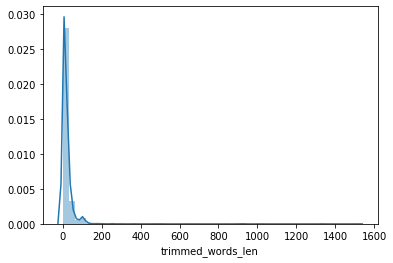

In [187]:
sns.distplot(df["trimmed_words_len"])

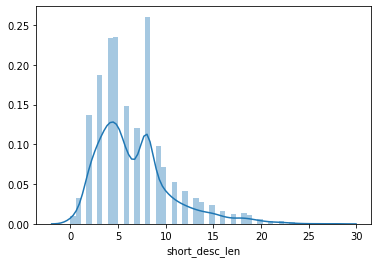

In [188]:
sns.distplot(df["short_desc_len"])

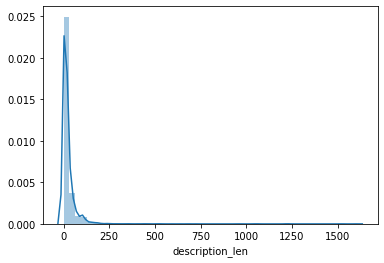

In [189]:
sns.distplot(df["description_len"])

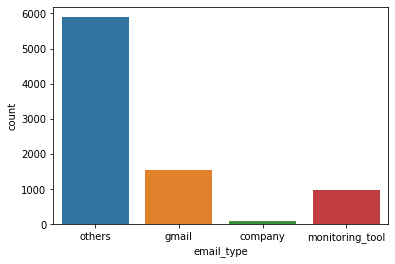

In [190]:
sns.countplot(df["email_type"])

In [191]:
df.head()

,Short description,Description,short_desc_lang,short_desc_en,description_lang,description_en,Caller,Assignment group,emails,email_type,...,flg_network,flg_outlook,flg_printer,flg_skype,flg_ticket_update,flg_vpn,flg_windows,host_related,blank_call,setup_ws
0,login issue,-verified user details.(employee# & manager na...,en,login issue,en,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,,others,...,0,0,0,0,0,0,0,0,0,0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,en,outlook,en,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,hmjdrvpb.komuaywn@gmail.com,gmail,...,0,1,0,1,0,0,0,0,0,0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,en,cant log in to vpn,en,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,eylqgodm.ybqkwiam@gmail.com,gmail,...,0,0,0,0,0,1,0,0,0,0
3,unable to access hr_tool page,unable to access hr_tool page,en,unable to access hr_tool page,en,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,,others,...,0,0,0,0,0,0,0,0,0,0
4,skype error,skype error,en,skype error,en,skype error,owlgqjme qhcozdfx,GRP_0,,others,...,0,0,0,1,0,0,0,0,0,0


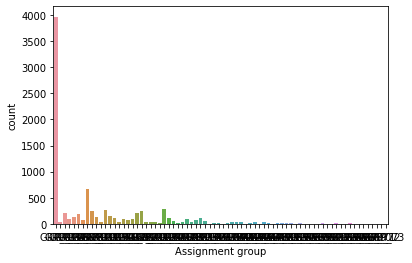

In [192]:
sns.countplot(df["Assignment group"])

In [193]:
a = df.groupby("Assignment group")
a["Assignment group"].count().sort_values(ascending = False)

Assignment group
GRP_0     3966
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_67       1
GRP_61       1
GRP_73       1
GRP_35       1
GRP_70       1
Name: Assignment group, Length: 74, dtype: int64

In [194]:
b = df.groupby("Short description")
print(b["Short description"].count().sort_values(ascending = False).head(10))

Short description
password reset               38
windows password reset       29
account locked in ad         24
windows account locked       23
erp SID_34 account unlock    19
blank call                   18
unable to connect to vpn     18
login issue                  18
account locked.              18
account unlock               17
Name: Short description, dtype: int64


In [195]:
b = df.groupby("Caller")
print(b["Caller"].count().sort_values(ascending = False).head(10))

Caller
bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
jloygrwh acvztedi     64
spxqmiry zpwgoqju     63
oldrctiu bxurpsyi     57
olckhmvx pcqobjnd     54
dkmcfreg anwmfvlg     51
Name: Caller, dtype: int64


In [196]:
df[df["mark_for_delete"]==1][["Short description","Description","trimmed_words","description_en_len","description_en_spl","trimmed_words_len","no_of_splch_removed1","no_of_splch_removed1_pct","no_of_splch_removed2_pct"]]

,Short description,Description,trimmed_words,description_en_len,description_en_spl,trimmed_words_len,no_of_splch_removed1,no_of_splch_removed1_pct,no_of_splch_removed2_pct
186,é’å²›å…´åˆæœºç”µshipment notificationé‚®ç®±è...,"from: \nsent: friday, october 28, 2016 7:20 a...",shipment notification sent friday october 28 2...,27,from sent friday october 28 2016 720 am to nwf...,24,30,58.8,13.5
276,outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...,outlookæ”¶åˆ°ç®±ä¸­folderå˜ä¸ºæ¯å¤©ä¸€ä¸ªfol...,outlook c folder folderoffice,4,outlook c folder folderoffice,4,48,65.8,65.8
469,ieæµè§ˆå™¨æ‰“å¼€crmç³»ç»ŸåŽæç¤ºç”¨æˆ·å·²è¢...,ieæµè§ˆå™¨æ‰“å¼€crmç³»ç»ŸåŽæç¤ºç”¨æˆ·å·²è¢...,ie crm zae crm ya,6,ie crm there zae crm ya,5,72,90,90
487,msd - office 2013 outlook æ‰“ä¸å¼€ï¼Œæ˜¾ç¤ºæ—...,please provide details of the issue.\n[â€Ž2016...,msd office 2013 outlook cs please provide deta...,38,please provide details of the issue 2016 z10 z...,37,54,67.5,46.6
618,outlookæ‰“ä¸å¼€,æ‰“å¼€outlookæ—¶ï¼Œæ˜¾ç¤ºoutlook.ostæ–‡ä»¶é”™è...,outlook outlookoutlookost,2,outlookoutlookost is,2,9,56.2,75
...,...,...,...,...,...,...,...,...,...
8266,erpæ— æ³•è¿›è¡Œé‡‡è´­ï¼ˆè½¬ç»™è´ºæ­£å¹³ï¼‰,"è¿›è¡Œé‡‡è´­æ—¶æ˜¾ç¤º""æ‰¾ä¸åˆ°å‘˜å·¥111115483...",erp 1111154833 scy c,4,1111154833 is scy c,4,39,92.9,85.7
8270,å¯†ç æ›´æ”¹åŽï¼Œoutlookæ— æ³•ç™»é™†,å¯†ç æ›´æ”¹åŽï¼Œoutlookæ— æ³•ç™»é™†,outlook,3,the outlook is,1,30,81.1,81.1
8457,æ— æ³•ç™»é™†hr_toolè€ƒå‹¤ç³»ç»Ÿ,æ˜¾ç¤ºjavaæ’ä»¶æ— æ³•åŠ è½½ï¼Œæ‰€éœ€ç‰ˆæœ¬1.8...,hrtool java pushkin 18045,5,java as pushkin 18045 is,4,24,77.4,81.4
8465,vpn è¿žæŽ¥ä¸ä¸Š,vpnè¿žä¸ä¸Šï¼Œè¯·è½¬ç»™ è´ºæ­£å¹³ atcbvglq.bd...,vpn vpn,1,vpn,2,12,75,48.4


In [197]:
df.to_excel("processed_data.xlsx")

## Summary of Columns : 

* Input file was loaded into a DataFrame. 
* It was observed that there are some records whcih are not in English. Tried to use googletran/ Transilator package in Python. However, they have limitation for no of free calls. Hence, loaded the data into google sheets and transilated
* In order to proces the data several new columns were created to undersatnd the no of special characters..etc
* Using tokenizer, word corpus was built with Max 1500 words. 
* Both short and long description was combined after removing special characters/ transilation to english/ applying Tokenizer
* Records where more than 50% characters are junk are marked for delete
* below is the list of new columns created


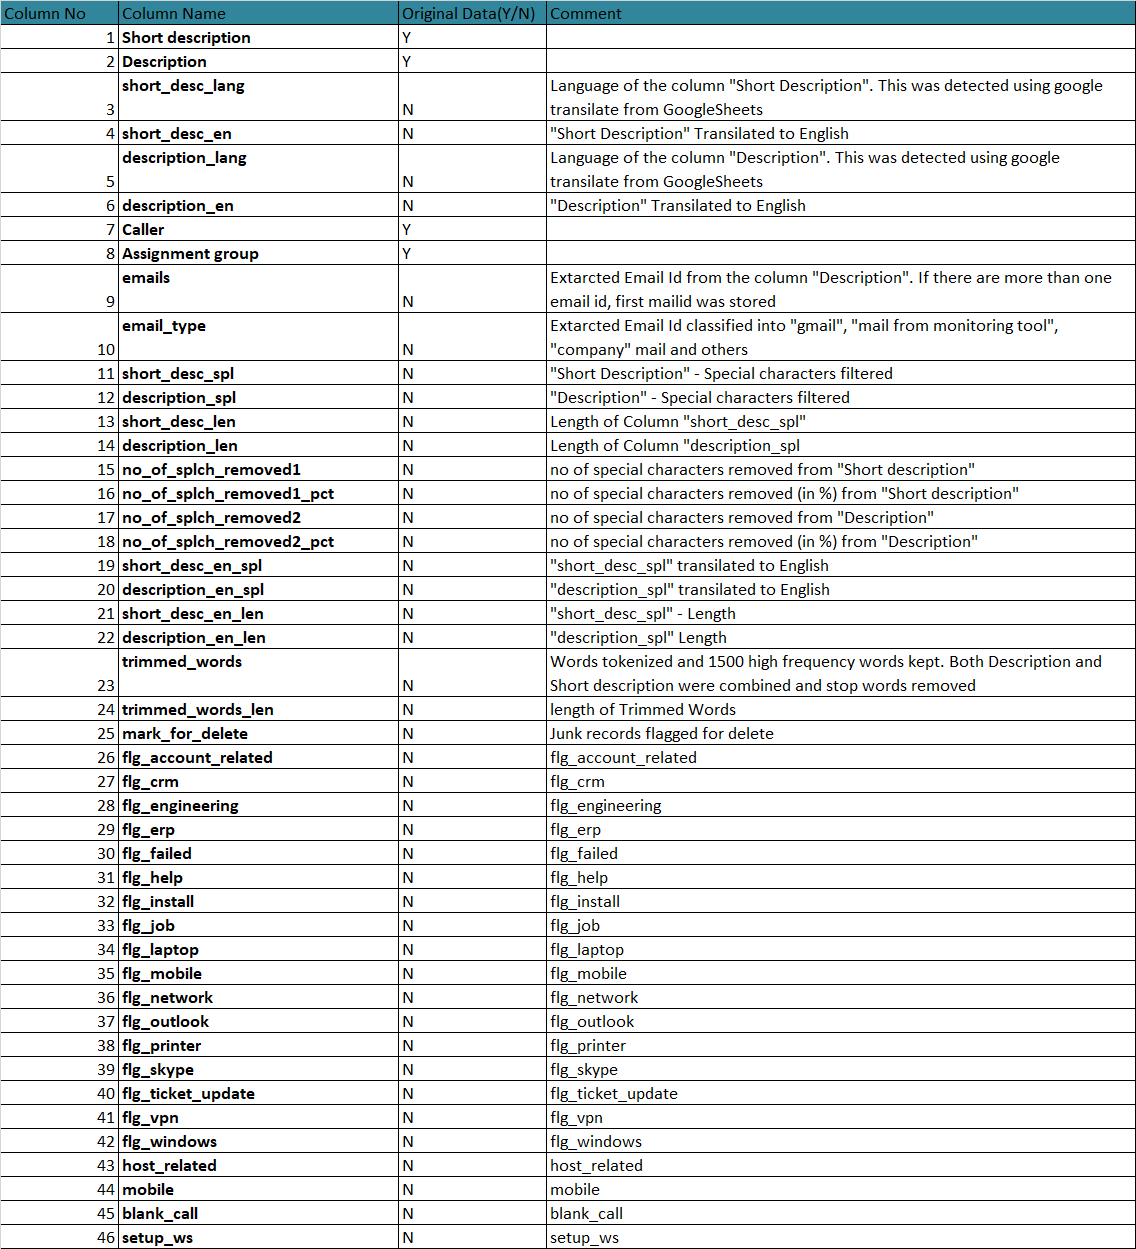


### Further processing 

Groups having less tickets should be combined as one group as we can not really make sence of them


In [198]:
# Dividing the Group by 75 - 25 %
a1 = df.groupby("Assignment group")["Assignment group"].count().sort_values(ascending = False)
thr = 75
print("Upto",thr,"% tickets Assignment Groups list :","\n ",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index)
new_group_75 = np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index
print("\n No of Selected groups : ",len(new_group_75), " out of ", len(a1), " total no of groups \n")
print("\n",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=101]*100/8500),2))

Upto 75 % tickets Assignment Groups list : 
  Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6'],
      dtype='object', name='Assignment group')

 No of Selected groups :  9  out of  74  total no of groups 


 Assignment group
GRP_0     46.66
GRP_8     54.44
GRP_24    57.84
GRP_12    60.86
GRP_9     63.82
          ...  
GRP_67    99.82
GRP_61    99.84
GRP_73    99.85
GRP_35    99.86
GRP_70    99.87
Name: Assignment group, Length: 74, dtype: float64


In [199]:
# Dividing the Group by 85 - 15 %

a1 = df.groupby("Assignment group")["Assignment group"].count().sort_values(ascending = False)
thr = 85
print("Upto",thr,"% tickets Assignment Groups list :","\n ",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index)
new_group_85 = np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index
print("\n No of Selected groups : ",len(new_group_85), " out of ", len(a1), " total no of groups \n")
print("\n",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=101]*100/8500),2))

Upto 85 % tickets Assignment Groups list : 
  Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29'],
      dtype='object', name='Assignment group')

 No of Selected groups :  17  out of  74  total no of groups 


 Assignment group
GRP_0     46.66
GRP_8     54.44
GRP_24    57.84
GRP_12    60.86
GRP_9     63.82
          ...  
GRP_67    99.82
GRP_61    99.84
GRP_73    99.85
GRP_35    99.86
GRP_70    99.87
Name: Assignment group, Length: 74, dtype: float64


In [200]:
# Dividing the Group by 95 - 5 %
a1 = df.groupby("Assignment group")["Assignment group"].count().sort_values(ascending = False)
thr = 95
print("Upto",thr,"% tickets Assignment Groups list :","\n ",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index)
new_group_95 = np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=thr]*100/8500),2).index
print("\n No of Selected groups : ",len(new_group_95), " out of ", len(a1), " total no of groups \n")
print("\n",np.round(np.cumsum(a1[np.cumsum(a1*100/8500)<=101]*100/8500),2))

Upto 95 % tickets Assignment Groups list : 
  Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29', 'GRP_18', 'GRP_16', 'GRP_17', 'GRP_31',
       'GRP_7', 'GRP_34', 'GRP_26', 'GRP_40', 'GRP_28', 'GRP_41', 'GRP_30',
       'GRP_15', 'GRP_42', 'GRP_20', 'GRP_45', 'GRP_22'],
      dtype='object', name='Assignment group')

 No of Selected groups :  33  out of  74  total no of groups 


 Assignment group
GRP_0     46.66
GRP_8     54.44
GRP_24    57.84
GRP_12    60.86
GRP_9     63.82
          ...  
GRP_67    99.82
GRP_61    99.84
GRP_73    99.85
GRP_35    99.86
GRP_70    99.87
Name: Assignment group, Length: 74, dtype: float64


In [205]:
df["new_group_75"] = ""
df["new_group_85"] = ""
df["new_group_95"] = ""


for i in (df.index):
    if df["Assignment group"][i] in new_group_75:
        df.loc[i,"new_group_75"] = df["Assignment group"][i]
    else :
        df.loc[i,"new_group_75"] = "GRP_9999"
    
    if df["Assignment group"][i] in new_group_85:
        df.loc[i,"new_group_85"] = df["Assignment group"][i]
    else :
        df.loc[i,"new_group_85"] = "GRP_9999"
    
    if df["Assignment group"][i] in new_group_95:
        df.loc[i,"new_group_95"] = df["Assignment group"][i]
    else :
        df.loc[i,"new_group_95"] = "GRP_9999"
    
        

In [207]:
a = df.groupby("new_group_95")
a = pd.DataFrame(a["new_group_95"].count().sort_values(ascending = False))
print(a)

              new_group_95
new_group_95              
GRP_0                 3966
GRP_8                  661
GRP_9999               418
GRP_24                 289
GRP_12                 257
GRP_9                  252
GRP_2                  241
GRP_19                 215
GRP_3                  200
GRP_6                  184
GRP_13                 145
GRP_10                 140
GRP_5                  129
GRP_14                 118
GRP_25                 116
GRP_33                 107
GRP_4                  100
GRP_29                  97
GRP_18                  88
GRP_16                  85
GRP_17                  81
GRP_31                  69
GRP_7                   68
GRP_34                  61
GRP_26                  56
GRP_40                  45
GRP_28                  44
GRP_41                  40
GRP_30                  39
GRP_15                  39
GRP_42                  37
GRP_20                  36
GRP_45                  35
GRP_22                  31


In [208]:
np.cumsum(a.new_group_95*100/8500)

new_group_95
GRP_0       46.658824
GRP_8       54.435294
GRP_9999    59.352941
GRP_24      62.752941
GRP_12      65.776471
GRP_9       68.741176
GRP_2       71.576471
GRP_19      74.105882
GRP_3       76.458824
GRP_6       78.623529
GRP_13      80.329412
GRP_10      81.976471
GRP_5       83.494118
GRP_14      84.882353
GRP_25      86.247059
GRP_33      87.505882
GRP_4       88.682353
GRP_29      89.823529
GRP_18      90.858824
GRP_16      91.858824
GRP_17      92.811765
GRP_31      93.623529
GRP_7       94.423529
GRP_34      95.141176
GRP_26      95.800000
GRP_40      96.329412
GRP_28      96.847059
GRP_41      97.317647
GRP_30      97.776471
GRP_15      98.235294
GRP_42      98.670588
GRP_20      99.094118
GRP_45      99.505882
GRP_22      99.870588
Name: new_group_95, dtype: float64

### Delete records marked for deletion


In [209]:
df_new = df[df["mark_for_delete"]==0]
print(df_new.shape)

(8379, 50)


In [210]:
len(df[df["mark_for_delete"]==1]["mark_for_delete"])

110

In [211]:
df_new.dtypes

Short description           object
Description                 object
short_desc_lang             object
short_desc_en               object
description_lang            object
description_en              object
Caller                      object
Assignment group            object
emails                      object
email_type                  object
short_desc_spl              object
description_spl             object
short_desc_len              object
description_len             object
no_of_splch_removed1        object
no_of_splch_removed1_pct    object
no_of_splch_removed2        object
no_of_splch_removed2_pct    object
short_desc_en_spl           object
description_en_spl          object
short_desc_en_len           object
description_en_len          object
trimmed_words               object
trimmed_words_len           object
trimmed_words_short         object
trimmed_words_long          object
mark_for_delete              int64
flg_account_related          int64
flg_crm             

In [212]:
df_new_1 = pd.DataFrame(df_new[["trimmed_words_short","trimmed_words_long","Assignment group","new_group_75","new_group_85","new_group_95"]])

In [214]:
# New DataFrame Created for Model Building...
df_new_1.to_excel("processed_trimmed_data.xlsx")

In [215]:
X = df_new["trimmed_words_short"]
y = df_new["new_group_75"]

Review length: 
Mean 34.48 words (18.846751)


Using TensorFlow backend.


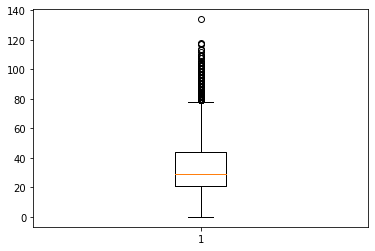

In [216]:
import numpy
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (numpy.mean(result), numpy.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [217]:
X1 = t.texts_to_sequences(X)

In [218]:
X2 = pad_sequences(X1, maxlen=200, padding = 'post', truncating = 'post') 
#X_test =  pad_sequences(X_test, maxlen=100, padding = 'post', truncating = 'post')

In [219]:
X2.shape

(8379, 200)

In [220]:
X2[0]

array([21, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [223]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

values = df_new["new_group_75"]
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

In [224]:
label_encoder.classes_

array(['GRP_0', 'GRP_12', 'GRP_19', 'GRP_2', 'GRP_24', 'GRP_3', 'GRP_6',
       'GRP_8', 'GRP_9', 'GRP_9999'], dtype=object)

In [225]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [226]:
onehot_encoded.shape

(8379, 10)

In [227]:
integer_encoded.shape

(8379, 1)

In [228]:
y = onehot_encoded
print(y)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [229]:
#Import all the required Libraries

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import Accuracy
import matplotlib.pyplot as plt
import collections
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Add
from tensorflow.keras.models import Model, Sequential

%matplotlib inline

In [230]:
#Split the dataset into Train and test
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size=0.2, random_state = 10, shuffle = True)
X_train.shape,y_train.shape, y_train[10], X_test.shape, y_test.shape

((6703, 200),
 (6703, 10),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (1676, 200),
 (1676, 10))

In [231]:
batch_size = 100
epochs = 25

In [232]:
X2[0]

array([21, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L1_Embedding (Embedding)     (None, 200, 200)          400000    
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 32)           19232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 99, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 32)            0         
_________________________________________________________________
L2_LSTM (Bidirectional)      (None, 99, 256)           164864    
_________________________________________________________________
L3_Flatten (Flatten)         (None, 25344)             0         
_______

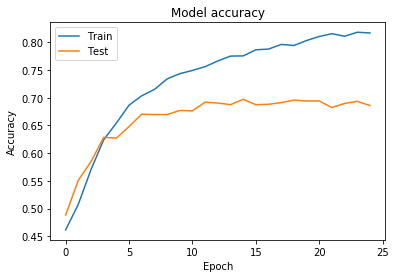

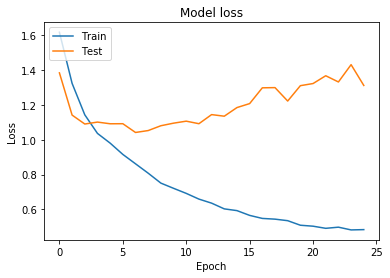

In [233]:
embedding_size = 200
maxlen = 200

# Crete a Sequential Model
model1 = Sequential()

# Add embedding as the first layer. We are going to initiate with the pre trained Glove vector. Since they are already trained embeddings
# We are going to make the trainable parameter 'false'
model1.add(Embedding(t.num_words, embedding_size, input_length = maxlen, trainable = True, name='L1_Embedding'))

#These embeddings are made non-trainable as they are pre trained to highly optimized values
model1.add(Conv1D(32,3,activation="relu"))
model1.add(MaxPooling1D(pool_size=2))

#Adding a Dropout ensures the model is not overfitting
model1.add(Dropout(0.5))

#Add Bi-Directional LSTM
model1.add(Bidirectional(LSTM(128, return_sequences = True, dropout = 0.2),name='L2_LSTM'))
model1.add(Flatten(name='L3_Flatten'))

# Add dense and Dropout 
model1.add(Dense(254, activation='relu',name='L4_Dense_relu'))
model1.add(Dropout(0.2, name  = "L5_Dropout"))

#Since this is a binary classification, we add the last layer as Dense with single neuron with Sigmoid. Based on the probability we can decide if the output is 0 or 1
model1.add(Dense(10, activation='sigmoid',name='L6_Dense_sigmoid'))

#Compile the model with binary cross entrophy and adam optimizer
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model1.summary()

# We are going to use validation split of 20%
history1 = model1.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split = 0.2, verbose = 2)

#Predect on the test data
y_pred = model1.predict(X_test)
#y_pred = (y_pred>0.5).astype(np.int)

#print results
#print("\n","Confusion Matrix :","\n",confusion_matrix(y_test,y_pred))
#print("\n","Classification Report :","\n",classification_report(y_test,y_pred))

# Print plot of Training and Validation Accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Print plot of Training and Validation Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [653]:
X_test[0], y_test[0]

(array([ 15,   9, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [654]:
y_pred1 = np.zeros(shape = y_pred.shape)
for i in tqdm(range(len(y_pred1))):
    y_pred1[i][np.argmax(y_pred[i])]=1    

100%|██████████| 1677/1677 [00:00<00:00, 336805.58it/s]


In [655]:
y_pred1[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [656]:
print("\n","Classification Report :","\n",classification_report(y_test,y_pred1))


 Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.86      0.82       792
           1       0.40      0.34      0.37        50
           2       0.24      0.11      0.15        55
           3       0.46      0.33      0.39        51
           4       0.81      0.54      0.64        54
           5       0.25      0.14      0.18        50
           6       0.45      0.14      0.21        36
           7       0.55      0.81      0.65       109
           8       0.70      0.65      0.67        54
           9       0.60      0.59      0.60       426

   micro avg       0.68      0.68      0.68      1677
   macro avg       0.52      0.45      0.47      1677
weighted avg       0.66      0.68      0.66      1677
 samples avg       0.68      0.68      0.68      1677



In [657]:
a_t = onehot_encoder.inverse_transform(y_test)
a_t1= onehot_encoder.inverse_transform(y_pred1)

In [658]:
print("\n","Confusion Matrix :","\n",confusion_matrix(a_t,a_t1))


 Confusion Matrix : 
 [[682   8   8   7   2   2   1   1   1  80]
 [  7  17   0   2   0   2   0   5   2  15]
 [ 25   0   6   0   0   7   0   0   0  17]
 [ 19   0   0  17   0   1   0   0   0  14]
 [  4   1   2   5  29   5   0   0   0   8]
 [ 27   0   4   3   0   7   0   0   0   9]
 [  0   0   0   0   0   0   5  15   6  10]
 [  2   1   0   0   0   0   3  88   4  11]
 [  5   1   1   0   1   0   0   5  35   6]
 [ 92  15   4   3   4   4   2  47   2 253]]


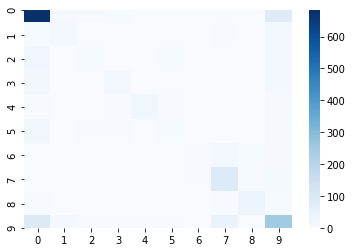

In [659]:
sns.heatmap(confusion_matrix(a_t,a_t1), cmap="Blues")